In [1]:
# The code was removed by Watson Studio for sharing.

# Coffee Venues in Melbourne Suburbs
This notebook analyses the number and quality of coffee venues in different Melbourne suburbs.  Data on venues is pulled from Foursquare, while data on suburbs in taken from the Australian Bureau of Statistics (ABS) website: https://www.abs.gov.au/websitedbs/D3310114.nsf/Home/2016%20QuickStats.  The suburb data was collected in the Australian Census of 2016.  
## Set Up
Import libraries for this notebook.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import requests
import re
import time
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import statsmodels.api as sm
from scipy import stats

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import seaborn as sns

from sklearn.model_selection import LeaveOneOut
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

print('Libraries imported.')

Libraries imported.


## Get Suburb Names, Postcodes and Coordinates
Scrape suburb names from Wikipedia page https://en.wikipedia.org/wiki/List_of_Melbourne_suburbs.  Use geopy library to geocode the suburbs.  
Load this data directly from csv if already collected.

In [3]:
# load from csv if already available, then skip next cells
my_file = project.get_file("suburbs_coords.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
suburbs_coords = pd.read_csv(my_file)
suburbs_coords.head(10)

,Name,Postcode,Lat,Long
0,Carlton,3053,-37.800153,144.966257
1,Carlton North,3054,-37.785981,144.974578
2,Docklands,3008,-37.818217,144.944507
3,East Melbourne,3002,-37.811003,144.979694
4,Flemington,3031,-37.791006,144.927291
5,Melbourne,3000,-37.817492,144.967871
6,Melbourne,3004,-37.837269,144.972655
7,North Melbourne,3051,-37.800645,144.949051
8,Parkville,3052,-37.794844,144.958504
9,Port Melbourne,3207,-37.836022,144.938044


In [31]:
# Scrape wikipedia page
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Melbourne_suburbs'
wiki_html = requests.get(wiki_url).text

page = BeautifulSoup(wiki_html, 'html.parser')

all_items = page.find_all('li')

names = []
postcode = []
code = re.compile("\d{4}")

# loop through all list items on page, extracting strings
for item in all_items:
    strings_list = list(item.stripped_strings)
    
    # find list items containing a postcode and append to output
    for i, string in enumerate(strings_list):
        match = re.match("\d{4}", string)
        
        if match:
            names.append(strings_list[0])
            postcode.append(code.findall(strings_list[i])[0])


# populate a dataframe, change postcode to numeric, drop rows with any missing data and drop duplicates        
suburbs = pd.DataFrame(list(zip(names, postcode)), columns=['Name', 'Postcode'])

suburbs['Postcode'] = pd.to_numeric(suburbs['Postcode'])
suburbs.dropna(how='any', inplace=True)
suburbs.drop_duplicates(inplace=True)
suburbs.astype({'Postcode': int})
suburbs.reset_index(drop=True, inplace=True)

print(suburbs.dtypes)
print(suburbs.shape)

Name        object
Postcode     int64
dtype: object
(533, 2)


In [ ]:
# get latitude and longitude data using geopy Nominatim
lat = []
long = []
areas = suburbs['Postcode']

geolocator = Nominatim(user_agent="Melbourne_explorer")

for i, area in enumerate(areas):
    address = '{}, Victoria, Australia'.format(area)
    #print(address)
    
    location = geolocator.geocode(address)
    
    if location:
        suburb_lat = location.latitude
        suburb_long = location.longitude
    else :
        suburb_lat = np.nan
        suburb_long = np.nan
        
    lat.append(suburb_lat)
    long.append(suburb_long)
    time.sleep(1)

lat_series = pd.Series(lat, name='Lat')
long_series = pd.Series(long, name='Long')

In [ ]:
print(suburbs.shape)
print(len(lat_series))
print(len(long_series))

In [33]:
# concat lat and long with suburbs data, remove duplicate postcodes with multiple suburbs
suburbs_coords = pd.concat([suburbs, lat_series, long_series], axis=1)
suburbs_coords.drop_duplicates(subset=['Postcode'], inplace=True)
suburbs_coords.reset_index(drop=True, inplace=True)
print('Shape:', suburbs_coords.shape)

suburbs_coords.head(20)

Shape: (278, 4)


,Name,Postcode,Lat,Long
0,Carlton,3053,-37.800153,144.966257
1,Carlton North,3054,-37.785981,144.974578
2,Docklands,3008,-37.818217,144.944507
3,East Melbourne,3002,-37.811003,144.979694
4,Flemington,3031,-37.791006,144.927291
5,Melbourne,3000,-37.817492,144.967871
6,Melbourne,3004,-37.837269,144.972655
7,North Melbourne,3051,-37.800645,144.949051
8,Parkville,3052,-37.794844,144.958504
9,Port Melbourne,3207,-37.836022,144.938044


In [34]:
# save results to csv
project.save_data(file_name = "suburbs_coords.csv", data = suburbs_coords.to_csv(index=False), overwrite=True)

{'file_name': 'suburbs_coords.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'pythonproject-donotdelete-pr-c7wkfixsup7w6u',
 'asset_id': '2fa829ef-7f2a-40c7-b1d8-017099534d25'}

## Determine Suburb Distance from CBD
In order to focus on closest suburbs to city, find suburb distance from CBD using *geopy* library.  Remove suburbs > 20 km from CBD for simplicity.  Load close suburbs data from csv if already available.

In [4]:
# load from csv if available and skip next cells.
my_file = project.get_file("close_suburbs.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
close_suburbs = pd.read_csv(my_file)
print('Shape:', close_suburbs.shape)
close_suburbs.head(10)

Shape: (128, 5)


,Name,Postcode,Lat,Long,Dist_CBD
0,Carlton,3053,-37.800153,144.966257,1.485492
1,Carlton North,3054,-37.785981,144.974578,3.158609
2,Docklands,3008,-37.818217,144.944507,1.926197
3,East Melbourne,3002,-37.811003,144.979694,1.275025
4,Flemington,3031,-37.791006,144.927291,4.196574
5,Melbourne,3000,-37.817492,144.967871,0.484663
6,Melbourne,3004,-37.837269,144.972655,2.708183
7,North Melbourne,3051,-37.800645,144.949051,2.039567
8,Parkville,3052,-37.794844,144.958504,2.164840
9,Port Melbourne,3207,-37.836022,144.938044,3.479474


In [35]:
# set coords of CBD and find distance for each suburb in km
CBD_coords = (-37.813526, 144.965568)

dist = []
areas = suburbs_coords['Name']

for i, area in enumerate(areas):
    sub_coords = (suburbs_coords.loc[i, 'Lat'], suburbs_coords.loc[i, 'Long'])
    dist.append(geodesic(sub_coords, CBD_coords).km)
    
dist_series = pd.Series(dist, name='Dist_CBD')
suburbs_dist = pd.concat([suburbs_coords, dist_series], axis=1)
suburbs_dist.head()

,Name,Postcode,Lat,Long,Dist_CBD
0,Carlton,3053,-37.800153,144.966257,1.485492
1,Carlton North,3054,-37.785981,144.974578,3.158609
2,Docklands,3008,-37.818217,144.944507,1.926197
3,East Melbourne,3002,-37.811003,144.979694,1.275025
4,Flemington,3031,-37.791006,144.927291,4.196574


In [36]:
# remove suburbs > 20 km from CBD
close_suburbs = suburbs_dist.loc[suburbs_dist['Dist_CBD'] < 20, :]
close_suburbs.shape

(128, 5)

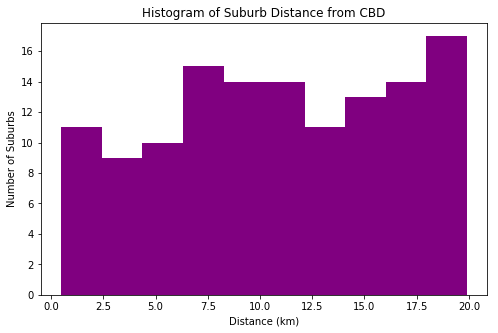

In [37]:
# visualise histogram of distances
close_suburbs['Dist_CBD'].plot(kind='hist', figsize=(8, 5), color='purple')

plt.title('Histogram of Suburb Distance from CBD')
plt.ylabel('Number of Suburbs')
plt.xlabel('Distance (km)')

plt.show()

In [38]:
# save results to csv
project.save_data(file_name = "close_suburbs.csv", data = close_suburbs.to_csv(index=False), overwrite=True)

{'file_name': 'close_suburbs.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'pythonproject-donotdelete-pr-c7wkfixsup7w6u',
 'asset_id': '71fed96a-6b34-4d48-9cf1-09350de20cec'}

## Pull Foursquare Coffee Venue Data
For each suburb, use Foursquare API to gather number of coffee venues and mean ratings.  From this data, determine number of venues and mean rating for each suburb.  If data is already available, then load from csv.

In [5]:
# load venue rating results if available.
my_file = project.get_file("final_venues_data.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
final_venues_data = pd.read_csv(my_file)
print('Shape:', final_venues_data.shape)
final_venues_data.head(10)

Shape: (2041, 6)


,Suburb,Venue_ID,Venue_Name,Venue_Lat,Venue_Long,Rating
0,Melbourne,4b27fe68f964a5205f8d24e3,120 Collins,-37.813592,144.969614,7.6
1,Alphington,56df907fcd106963bd72c493,15 Pounds,-37.779655,145.016780,NaN
2,Brunswick East,5d7311ed4a3a31000850e5e2,1851,-37.776694,144.971182,NaN
3,Mont Albert,56db571f498e337ce490825a,1855 Cafe,-37.814730,145.098610,NaN
4,Moorabbin,4de85cad1838b9ad8d0d5fc7,191 Cafe,-37.944588,145.059440,NaN
5,Thornbury,55f9f44a498ed94af874094a,2 Latte,-37.757220,145.000663,7.2
6,Maribyrnong,4d9166c75f33b1f756886d7e,2 One 2,-37.773205,144.915761,NaN
7,North Melbourne,5ca80808f00a70002cf0aac9,279,-37.805601,144.952019,NaN
8,Burnley,4fcd7e5de4b02f8c77af93f7,3 Lives Cafe,-37.828832,144.995325,6.5
9,Brunswick,4c05c547517d0f471719f515,332 Victoria St Brunswick,-37.767087,144.961801,NaN


In [6]:
# load suburb venue data if available and skip next cells.
my_file = project.get_file("suburb_venue.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
suburb_venue = pd.read_csv(my_file)
print('Shape:', suburb_venue.shape)
suburb_venue.head(10)

Shape: (127, 8)


,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating
0,Carlton,3053,-37.800153,144.966257,1.485492,16,13,7.830769
1,Carlton North,3054,-37.785981,144.974578,3.158609,47,16,7.400000
2,Docklands,3008,-37.818217,144.944507,1.926197,19,7,6.757143
3,East Melbourne,3002,-37.811003,144.979694,1.275025,23,15,7.300000
4,Flemington,3031,-37.791006,144.927291,4.196574,26,10,7.220000
5,Melbourne,3000,-37.817492,144.967871,0.484663,48,37,7.864865
6,North Melbourne,3051,-37.800645,144.949051,2.039567,11,5,8.460000
7,Parkville,3052,-37.794844,144.958504,2.164840,1,1,7.300000
8,Port Melbourne,3207,-37.836022,144.938044,3.479474,50,19,6.842105
9,Southbank,3006,-37.825781,144.964151,1.365902,20,15,7.080000


In [4]:
# The code was removed by Watson Studio for sharing.

In [ ]:
# define function to obtain venue information for all suburbs
def getVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent=browse&categoryId=4bf58dd8d48988d16d941735'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['id'], 
            v['name'],
            v['location']['lat'],
            v['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 'Venue_ID', 'Venue_Name', 'Venue_Lat', 'Venue_Long']
    
    return(nearby_venues)

In [ ]:
# get coffee venue information for all suburbs
VERSION = '20180605'
RADIUS = 1000
LIMIT = 50

venues = getVenues(names=close_suburbs['Name'], latitudes=close_suburbs['Lat'], longitudes=close_suburbs['Long'], radius=RADIUS)

print(venues.shape)
venues.head()

In [ ]:
# clean up venue data by removing duplicates - assign duplicate venues to closest suburb
venues_dist = pd.merge(left=venues, right=close_suburbs.loc[:, ['Name', 'Lat', 'Long']], how='left', left_on='Suburb', right_on='Name')

dist_list = []

for i, venue in enumerate(list(venues['Venue_Name'])):
    dist_list.append(geodesic((venues_dist.loc[i, 'Venue_Lat'], venues_dist.loc[i, 'Venue_Long']), (venues_dist.loc[i, 'Lat'], venues_dist.loc[i, 'Long'])).km)

dist_series = pd.Series(dist_list, name='Dist')
venues_dist = pd.concat([venues_dist, dist_series], axis=1)
venues_dist.sort_values(['Venue_Name', 'Dist'], ascending=True, inplace=True)

venues_dist.drop_duplicates(subset=['Venue_ID'], keep='first', inplace=True)
venues_dist.reset_index(drop=True, inplace=True)
print('Shape:', venues_dist.shape)

venues_dist.head(20)

In [ ]:
# remove unecessary columns
venues = venues_dist.drop(['Name', 'Lat', 'Long', 'Dist'], axis=1)
venues.head()

In [ ]:
# save to csv
project.save_data(file_name = "venues.csv", data = venues.to_csv(index=False), overwrite=True)

In [ ]:
# define function to obtain venue rating for all venues
def getRating(venue_IDs):
    
    rating_list=[]
    for venue_id in venue_IDs:
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['venue']['rating']
        except KeyError:
            results = np.nan
        
        # return only relevant information for each venue
        rating_list.append(results)
        
    rating_series = pd.Series(rating_list, name = 'Rating')
    
    return(rating_series)


In [7]:
# get rating information for all venues (in multiple days due to API limits)
VERSION = '20180605'

venue_IDs1 = list(no_rating['Venue_ID'][1400:])

ratings1 = getRating(venue_IDs1)


In [8]:
# change index for later sets of values
ratings1.index = pd.RangeIndex(start=1400, stop=1674, step=1)
ratings1[:5]

1400    6.1
1401    6.1
1402    6.5
1403    8.5
1404    NaN
Name: Rating, dtype: float64

In [9]:
# add ratings to venue dataframe
# this was done by creating a dataframe called no_rating,  containing venues where rating data was required
# all rating info was added to the no_rating frame

#no_rating = pd.concat([no_rating, ratings1], axis=1)

# or add ratings to venue_ratings dataframe if already present after day 1
no_rating.at[1400:, ['Rating']] = ratings1


In [20]:
# merge new ratings to venues_data
venues_data = pd.merge(left=venues_data, right=no_rating.loc[:, ['Venue_ID', 'Rating']], how='left', on='Venue_ID')
print('Shape:', venues_data.shape)
print(venues_data.dtypes)
venues_data.tail(10)

Shape: (2041, 7)
Suburb         object
Venue_ID       object
Venue_Name     object
Venue_Lat     float64
Venue_Long    float64
Rating_x      float64
Rating_y      float64
dtype: object


,Suburb,Venue_ID,Venue_Name,Venue_Lat,Venue_Long,Rating_x,Rating_y
2031,Armadale,512957bfe4b0522e5b4946d6,thelovebird,-37.855584,145.022396,NaN,NaN
2032,Hughesdale,50cbb4fae4b0a8af7f25f8ab,tj's Lunch & Cafe,-37.900300,145.091000,NaN,NaN
2033,Brunswick,53ab86e2498ed8489244d59b,tre bar,-37.766388,144.961509,NaN,NaN
2034,Docklands,552b3374498e147ac86d7da7,tukk & co,-37.817725,144.949840,NaN,8.5
2035,Caulfield,52b65555498e74640cd74667,turquoise,-37.893880,145.020860,NaN,NaN
2036,Eaglemont,57228832498e3c0f95771930,two peas in a pod deli,-37.742734,145.065295,NaN,NaN
2037,Melbourne Airport,5701c621498e5315af5ff5e0,velocity espresso & bar,-37.672816,144.847871,NaN,NaN
2038,Flemington,523a65f211d24c4ed765f5a9,white rabbit Record Bar,-37.793669,144.930296,NaN,NaN
2039,Elwood,4b7f727cf964a5201f2f30e3,wicked,-37.885392,144.987455,NaN,NaN
2040,Box Hill,4f542c93e4b07de37d7e3493,wpps canteen,-37.832633,145.120349,NaN,NaN


In [31]:
# combine Rating columns to create a list containing all ratings
Rating = []
Rating_x_na = venues_data['Rating_x'].isna()
Rating_y_na = venues_data['Rating_y'].isna()

for i, name in enumerate(venues_data['Venue_Name']):
    if Rating_x_na[i] == False:
        Rating.append(venues_data['Rating_x'][i])
    elif Rating_y_na[i] == False:
        Rating.append(venues_data['Rating_y'][i])
    else:
        Rating.append(np.nan)

Rating[:20]

[7.6,
 nan,
 nan,
 nan,
 nan,
 7.2,
 nan,
 nan,
 6.5,
 nan,
 5.9,
 6.4,
 8.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 7.6]

In [33]:
# add final Ratings column to venues_data to create a final_venues_data dataframe
Rating_ser = pd.Series(Rating, name = 'Rating')

final_venues_data = pd.concat([venues_data, Rating_ser], axis=1)
final_venues_data.drop(['Rating_x', 'Rating_y'], axis=1, inplace=True)

print('Shape:', final_venues_data.shape)

final_venues_data.tail(20)

Shape: (2041, 6)


,Suburb,Venue_ID,Venue_Name,Venue_Lat,Venue_Long,Rating
2021,Docklands,559c8ef2498e98fd9bcc6319,sargon,-37.817884,144.949175,NaN
2022,Port Melbourne,4b12eb39f964a520d49023e3,seven:am,-37.839864,144.941155,7.9
2023,Port Melbourne,4d0a8ae4d8d78cfaa65d17be,spuntino,-37.840794,144.932638,6.0
2024,Albanvale,57ebae7ccd108335b65d84ad,stalbans shisha,-37.745129,144.801024,NaN
2025,Port Melbourne,52c0ba45498ee80f0dd61e7a,syndicate,-37.836317,144.943677,NaN
2026,Alphington,57c25b90498e92026f8cc5ff,the blooming barista,-37.779401,145.016782,NaN
2027,Williamstown,4c676a0be75ac928c8c3fada,the chocolate room,-37.859228,144.900650,NaN
2028,Keilor East,541bbec4498ef6d4a6305f56,the east pantry,-37.736794,144.861388,NaN
2029,Brunswick,4b6e00b0f964a52093a22ce3,the empire strikes back,-37.770633,144.961540,NaN
2030,Moorabbin,5664edbc498e4003e44c77a1,the tradesman,-37.946978,145.055886,NaN


In [34]:
# save results to csv
project.save_data(file_name = "final_venues_data.csv", data = final_venues_data.to_csv(index=False), overwrite=True)

{'file_name': 'final_venues_data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'pythonproject-donotdelete-pr-c7wkfixsup7w6u',
 'asset_id': '2f8372de-f675-4b37-97ba-0ec55f0a1f3e'}

In [35]:
# what proportion of venues have ratings?
print('Number of Ratings:', final_venues_data.loc[~pd.isnull(final_venues_data['Rating']), :].shape[0])
print('Number of Venues:', final_venues_data.shape[0])

Number of Ratings: 670
Number of Venues: 2041


**33%** of coffee venues in these suburbs have ratings in Foursquare.

In [10]:
# count number of venues per suburb
venue_count = final_venues_data.groupby('Suburb').count()
venue_count.reset_index(inplace=True)

# mean rating for suburbs with ratings
venue_mean = final_venues_data.groupby('Suburb').mean()
venue_mean.reset_index(inplace=True)

# check number of rows
print('close_suburbs shape:', close_suburbs.shape)
print('venue_count shape:', venue_count.shape)
print('venue_mean shape:', venue_mean.shape)

# suburbs with no venues
print('Suburbs without venue data:')
no_data_suburb = close_suburbs.loc[~close_suburbs['Name'].isin(venue_count['Suburb']), :]
no_data_suburb
#close_suburbs.loc[close_suburbs['Postcode'].isin(no_data_suburb['Postcode']), :]

close_suburbs shape: (128, 5)
venue_count shape: (121, 6)
venue_mean shape: (121, 4)
Suburbs without venue data:


,Name,Postcode,Lat,Long,Dist_CBD
31,Macleod,3085,-37.721548,145.099839,15.626261
38,Attwood,3049,-37.666893,144.882653,17.840578
41,Coolaroo,3048,-37.658489,144.923885,17.595690
43,Keilor,3036,-37.710920,144.820912,17.092903
70,Doncaster East,3109,-37.774271,145.173056,18.787302
71,Donvale,3111,-37.780010,145.185968,19.764797


Just six suburbs within 20 km of CBD have no coffee venues by these criteria.  The venue count for these suburbs will be set to zero.  Also, the duplicated data for the suburb of Melbourne will be removed.

In [16]:
# merge suburb data with venue count data and mean rating data
suburb_venue_temp = pd.merge(left=close_suburbs, right=venue_count.loc[:, ['Suburb', 'Venue_ID', 'Rating']], how='left', left_on='Name', right_on='Suburb')
suburb_venue_temp.drop(['Suburb'], axis=1, inplace=True)
suburb_venue_temp.rename(columns={'Venue_ID':'Venue_Count', 'Rating':'Rating_Count'}, inplace=True)

suburb_venue = pd.merge(left=suburb_venue_temp, right=venue_mean.loc[:, ['Suburb', 'Rating']], how='left', left_on='Name', right_on='Suburb')
suburb_venue.drop(['Suburb'], axis=1, inplace=True)
suburb_venue.rename(columns={'Rating':'Mean_Rating'}, inplace=True)

suburb_venue.at[pd.isnull(suburb_venue['Venue_Count']), ['Rating_Count']] = 0
suburb_venue.at[pd.isnull(suburb_venue['Venue_Count']), ['Venue_Count']] = 0
suburb_venue.drop_duplicates(subset=['Name'], inplace=True)
suburb_venue.reset_index(drop=True, inplace=True)
suburb_venue['Venue_Count'] = suburb_venue['Venue_Count'].astype(int)
suburb_venue['Rating_Count'] = suburb_venue['Rating_Count'].astype(int)

print('Shape:', suburb_venue.shape)
suburb_venue.head()

Shape: (127, 8)


,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating
0,Carlton,3053,-37.800153,144.966257,1.485492,16,13,7.830769
1,Carlton North,3054,-37.785981,144.974578,3.158609,47,16,7.400000
2,Docklands,3008,-37.818217,144.944507,1.926197,19,7,6.757143
3,East Melbourne,3002,-37.811003,144.979694,1.275025,23,15,7.300000
4,Flemington,3031,-37.791006,144.927291,4.196574,26,10,7.220000


In [17]:
# save results to csv
project.save_data(file_name = "suburb_venue.csv", data = suburb_venue.to_csv(index=False), overwrite=True)

{'file_name': 'suburb_venue.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'pythonproject-donotdelete-pr-c7wkfixsup7w6u',
 'asset_id': 'aa221f87-a1de-4392-880b-98ac93bfe8fc'}

In [ ]:
# install package for plotting Folium maps
!conda install -c conda-forge folium=0.5.0 --yes
import folium

We can visualise the venue data on a map.

In [ ]:
# centre map on CBD
latitude = -37.813526
longitude = 144.965568

# colours
blues = cm.get_cmap('YlOrRd', 128)

# create map
map_venues = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
for lat, lon, poi, count in zip(suburb_venue['Lat'], suburb_venue['Long'], suburb_venue['Name'], suburb_venue['Venue_Count']):
    label = folium.Popup(str(poi) + '\nCount ' + str(count), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color="gray",
        fill=True,
        fill_color=colors.rgb2hex(blues(count / 50)),
        fill_opacity=0.7).add_to(map_venues)
       
map_venues

## Obtain Suburb Information from Census Data
Use the ABS website to scrape information on the make up of each suburb.  The ABS designate each suburb by SSC code.  These codes are avilable as a csv file from the ABS website.  
If all data has already been obtained then load from a csv file.

In [6]:
# If suburb data already exists as csv then run this cell and ignore cells below
my_file = project.get_file("suburb_data.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
suburb_data = pd.read_csv(my_file)
print('Shape:', suburb_data.shape)
suburb_data.head(10)

Shape: (215, 12)


,Name,Postcode,Lat,Long,Dist_CBD,SSC_CODE_2016,Residents,Median_age,Families,Mean_children,Dwellings,Median_income
0,Carlton,3053,-37.800153,144.966257,1.485492,20492,18535,24.0,2488,0.2,10180,572.0
1,Carlton North,3054,-37.785981,144.974578,3.158609,20493,6300,33.0,1384,0.4,3067,2039.0
2,Docklands,3008,-37.818217,144.944507,1.926197,20760,10964,30.0,2556,0.2,6499,1868.0
3,East Melbourne,3002,-37.811003,144.979694,1.275025,20824,4964,38.0,1107,0.2,2923,2285.0
4,Flemington,3031,-37.791006,144.927291,4.196574,20923,7719,33.0,1662,0.6,3687,1171.0
5,Kensington,3031,-37.791006,144.927291,4.196574,21319,10812,33.0,2590,0.4,5255,1956.0
6,Melbourne,3000,-37.817492,144.967871,0.484663,21629,47285,27.0,8021,0.1,28616,1148.0
7,Melbourne,3004,-37.837269,144.972655,2.708183,21629,47285,27.0,8021,0.1,28616,1148.0
8,North Melbourne,3051,-37.800645,144.949051,2.039567,21954,14940,28.0,2698,0.3,7512,1236.0
9,Parkville,3052,-37.794844,144.958504,2.164840,22026,7409,26.0,968,0.3,2443,1610.0


In [22]:
# load SSC codes
my_file = project.get_file("SSC_2016_AUST.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
ssc_codes = pd.read_csv(my_file)
ssc_codes.head(10)

,MB_CODE_2016,SSC_CODE_2016,SSC_NAME_2016,STATE_CODE_2016,STATE_NAME_2016,AREA_ALBERS_SQKM
0,10310310000,12402,Lower Boro,1,New South Wales,38.6513
1,10310350000,12402,Lower Boro,1,New South Wales,55.4296
2,10310330000,12402,Lower Boro,1,New South Wales,19.7428
3,11204634100,13062,Oallen,1,New South Wales,119.0986
4,11205382200,13062,Oallen,1,New South Wales,72.1115
5,10309860000,12402,Lower Boro,1,New South Wales,11.7983
6,10310320000,12402,Lower Boro,1,New South Wales,23.6359
7,10310340000,12402,Lower Boro,1,New South Wales,22.4047
8,10576170000,10547,Braidwood,1,New South Wales,4.9363
9,10576190000,10547,Braidwood,1,New South Wales,17.2555


In [23]:
# clean up ssc codes
ssc_vic = ssc_codes.loc[ssc_codes['STATE_NAME_2016'] == 'Victoria', ['SSC_CODE_2016', 'SSC_NAME_2016', 'STATE_NAME_2016']]
ssc_vic.drop_duplicates(inplace=True)
ssc_vic.reset_index(drop=True, inplace=True)

# remove (Vic.) from names
ssc_vic["SSC_NAME_2016"] = ssc_vic["SSC_NAME_2016"].replace(r" \(Vic\.\)", "", regex=True)


In [24]:
# merge codes with suburbs data and drop suburbs without codes
suburb_ssc = pd.merge(left=close_suburbs, right=ssc_vic.loc[:, ['SSC_NAME_2016', 'SSC_CODE_2016']], how='left', left_on='Name', right_on='SSC_NAME_2016')
suburb_ssc.dropna(how='any', inplace=True)
suburb_ssc.reset_index(drop=True, inplace=True)
suburb_ssc.drop('SSC_NAME_2016', axis=1, inplace=True)
suburb_ssc['SSC_CODE_2016'] = suburb_ssc['SSC_CODE_2016'].astype(dtype='int64')

print(suburb_ssc.shape)
suburb_ssc.head()

(126, 6)


,Name,Postcode,Lat,Long,Dist_CBD,SSC_CODE_2016
0,Carlton,3053,-37.800153,144.966257,1.485492,20492
1,Carlton North,3054,-37.785981,144.974578,3.158609,20493
2,Docklands,3008,-37.818217,144.944507,1.926197,20760
3,East Melbourne,3002,-37.811003,144.979694,1.275025,20824
4,Flemington,3031,-37.791006,144.927291,4.196574,20923


In [25]:
# define function to obtain suburb information
def getSuburbData(SSC_codes):
    
    res_list=[]
    age_list=[]
    fam_list=[]
    children_list=[]
    dwellings_list=[]
    income_list=[]
    
    for SSC_code in SSC_codes:
                    
        # load the relevant page
        abs_url = 'https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC'+str(SSC_code)+'?opendocument'
        abs_html = requests.get(abs_url).text
        page = BeautifulSoup(abs_html, 'html.parser')
        
        # scrape the relevant data
        try:
            people = page.find(class_='summaryTable qsPeople')
            res_list.append(list(people.stripped_strings)[1])
            age_list.append(list(people.stripped_strings)[7])
            
        except AttributeError:
            res_list.append(np.nan)
            age_list.append(np.nan)
        
        try:
            families = page.find(class_='summaryTable qsFamilies')
            fam_list.append(list(families.stripped_strings)[1])
            children_list.append(list(families.stripped_strings)[6])
            
        except AttributeError:
            fam_list.append(np.nan)
            children_list.append(np.nan)
        
        try:
            dwellings = page.find(class_='summaryTable qsDwelling')
            dwellings_list.append(list(dwellings.stripped_strings)[1])
            income_list.append(list(dwellings.stripped_strings)[5])
            
        except AttributeError:
            dwellings_list.append(np.nan)
            income_list.append(np.nan)
        
    suburb_data = pd.DataFrame(list(zip(res_list, age_list, fam_list, children_list, dwellings_list, income_list)), columns = ['Residents', 'Median_age', 'Families', 'Mean_children', 'Dwellings', 'Median_income'])
    
    return(suburb_data)


In [ ]:
# scrape suburb data
suburb_data = getSuburbData(suburb_ssc['SSC_CODE_2016'])
suburb_data.head()

In [64]:
# remove , and $ text and check for missing data
suburb_data.replace(to_replace=r',', value='', regex=True, inplace=True)
suburb_data.replace(to_replace=r'\$', value='', regex=True, inplace=True)

suburb_data.loc[pd.isnull(suburb_data_temp['Mean_children']), :]


,Residents,Median_age,Families,Mean_children,Dwellings,Median_income
68,0,NaN,0,NaN,0,NaN
143,0,NaN,0,NaN,0,NaN
194,0,NaN,0,NaN,0,NaN
206,0,NaN,0,NaN,0,NaN


Suburbs with no census data contained no residents in 2016.  Zero values will be entered as appropriate.

In [70]:
# replace some missing values with zero
suburb_data.loc[pd.isnull(suburb_data['Residents']), ['Residents', 'Families', 'Dwellings']] = 0

# change data types
suburb_data['Residents'] = pd.to_numeric(suburb_data['Residents'], errors='coerce')
suburb_data['Median_age'] = pd.to_numeric(suburb_data['Median_age'], errors='coerce')
suburb_data['Families'] = pd.to_numeric(suburb_data['Families'], errors='coerce')
suburb_data['Mean_children'] = pd.to_numeric(suburb_data['Mean_children'], errors='coerce')
suburb_data['Dwellings'] = pd.to_numeric(suburb_data['Dwellings'], errors='coerce')
suburb_data['Median_income'] = pd.to_numeric(suburb_data['Median_income'], errors='coerce')

# concat data with close suburbs data
suburb_data = pd.concat([suburb_ssc, suburb_data], axis=1)
suburb_data.reset_index(drop=True, inplace=True)
suburb_data.head()

,Name,Postcode,Lat,Long,Dist_CBD,SSC_CODE_2016,Residents,Median_age,Families,Mean_children,Dwellings,Median_income
0,Carlton,3053,-37.800153,144.966257,1.485492,20492,18535,24.0,2488,0.2,10180,572.0
1,Carlton North,3054,-37.785981,144.974578,3.158609,20493,6300,33.0,1384,0.4,3067,2039.0
2,Docklands,3008,-37.818217,144.944507,1.926197,20760,10964,30.0,2556,0.2,6499,1868.0
3,East Melbourne,3002,-37.811003,144.979694,1.275025,20824,4964,38.0,1107,0.2,2923,2285.0
4,Flemington,3031,-37.791006,144.927291,4.196574,20923,7719,33.0,1662,0.6,3687,1171.0


In [72]:
# save results to csv
project.save_data(file_name = "suburb_data.csv", data = suburb_data.to_csv(index=False), overwrite=True)

{'file_name': 'suburb_data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'pythonproject-donotdelete-pr-c7wkfixsup7w6u',
 'asset_id': 'fa696f33-7bfa-4880-a5a2-f5897b6d30c3'}

In [73]:
suburb_data.tail(10)

,Name,Postcode,Lat,Long,Dist_CBD,SSC_CODE_2016,Residents,Median_age,Families,Mean_children,Dwellings,Median_income
205,Essendon,3040,-37.749533,144.919474,8.181438,20879,20596,37.0,5173,0.7,9109,1775.0
206,Essendon Fields,3041,-37.722296,144.900394,11.640786,20880,0,NaN,0,NaN,0,NaN
207,Essendon North,3041,-37.722296,144.900394,11.640786,20881,2987,36.0,757,0.5,1438,1588.0
208,Essendon West,3040,-37.749533,144.919474,8.181438,20882,1439,40.0,392,0.9,608,1691.0
209,Moonee Ponds,3039,-37.767055,144.925080,6.270737,21730,14250,37.0,3587,0.6,6357,1861.0
210,Niddrie,3042,-37.723659,144.859498,13.668567,21930,5479,39.0,1495,0.8,2299,1764.0
211,Strathmore,3041,-37.722296,144.900394,11.640786,22369,8419,40.0,2264,1.0,3135,2107.0
212,Strathmore Heights,3041,-37.722296,144.900394,11.640786,22370,1004,41.0,278,0.8,395,1810.0
213,Travancore,3032,-37.774075,144.912849,6.382392,22559,2480,29.0,572,0.3,1273,1452.0
214,Laverton North,3026,-37.828674,144.795020,15.109844,21468,73,52.0,7,0.1,57,630.0


## Combine Suburb Data with Venue Data
To complete the data set for this project, combine the suburb data with the venue data.  Load from csv if already available.

In [3]:
# If final data already exists as csv then run this cell and ignore cells below
my_file = project.get_file("final_data.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
final_data = pd.read_csv(my_file)

print('Shape:', final_data.shape)
final_data.head(10)

Shape: (125, 14)


,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating,Residents,Median_age,Families,Mean_children,Dwellings,Median_income
0,Carlton,3053,-37.800153,144.966257,1.485492,16,13,7.830769,18535.0,24.0,2488.0,0.2,10180.0,572.0
1,Carlton North,3054,-37.785981,144.974578,3.158609,47,16,7.400000,6300.0,33.0,1384.0,0.4,3067.0,2039.0
2,Docklands,3008,-37.818217,144.944507,1.926197,19,7,6.757143,10964.0,30.0,2556.0,0.2,6499.0,1868.0
3,East Melbourne,3002,-37.811003,144.979694,1.275025,23,15,7.300000,4964.0,38.0,1107.0,0.2,2923.0,2285.0
4,Flemington,3031,-37.791006,144.927291,4.196574,26,10,7.220000,7719.0,33.0,1662.0,0.6,3687.0,1171.0
5,Melbourne,3000,-37.817492,144.967871,0.484663,48,37,7.864865,47285.0,27.0,8021.0,0.1,28616.0,1148.0
6,North Melbourne,3051,-37.800645,144.949051,2.039567,11,5,8.460000,14940.0,28.0,2698.0,0.3,7512.0,1236.0
7,Parkville,3052,-37.794844,144.958504,2.164840,1,1,7.300000,7409.0,26.0,968.0,0.3,2443.0,1610.0
8,Port Melbourne,3207,-37.836022,144.938044,3.479474,50,19,6.842105,16175.0,40.0,4247.0,0.4,8823.0,2190.0
9,Southbank,3006,-37.825781,144.964151,1.365902,20,15,7.080000,18709.0,30.0,3961.0,0.1,11569.0,1851.0


In [29]:
# merge venue data with suburbs data
final_data = pd.merge(left=suburb_venue, right=suburb_data.loc[:, ['Name', 'Residents', 'Median_age', 'Families', 'Mean_children', 'Dwellings', 'Median_income']], how='left', on='Name')

# remove suburbs with no census data
final_data.dropna(subset=['Residents'], inplace=True)
final_data.drop_duplicates(inplace=True)
final_data.reset_index(drop=True, inplace=True)

print('Shape:', final_data.shape)
final_data.head()

Shape: (125, 14)


,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating,Residents,Median_age,Families,Mean_children,Dwellings,Median_income
0,Carlton,3053,-37.800153,144.966257,1.485492,16,13,7.830769,18535.0,24.0,2488.0,0.2,10180.0,572.0
1,Carlton North,3054,-37.785981,144.974578,3.158609,47,16,7.400000,6300.0,33.0,1384.0,0.4,3067.0,2039.0
2,Docklands,3008,-37.818217,144.944507,1.926197,19,7,6.757143,10964.0,30.0,2556.0,0.2,6499.0,1868.0
3,East Melbourne,3002,-37.811003,144.979694,1.275025,23,15,7.300000,4964.0,38.0,1107.0,0.2,2923.0,2285.0
4,Flemington,3031,-37.791006,144.927291,4.196574,26,10,7.220000,7719.0,33.0,1662.0,0.6,3687.0,1171.0


In [31]:
suburb_venue.loc[~suburb_venue['Name'].isin(final_data['Name']), :]

,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating
24,Bellfield,3081,-37.735707,145.049696,11.381399,5,0,NaN
98,Monash University,3800,-37.911134,145.131805,18.203297,24,9,6.8


In [20]:
# save results to csv
project.save_data(file_name = "final_data.csv", data = final_data.to_csv(index=False), overwrite=True)

{'file_name': 'final_data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'pythonproject-donotdelete-pr-c7wkfixsup7w6u',
 'asset_id': 'd66e3995-29c1-41cc-af42-f0e8ca5174d0'}

## Exploratory Data Analysis
Visualise variable distributions and correlations.

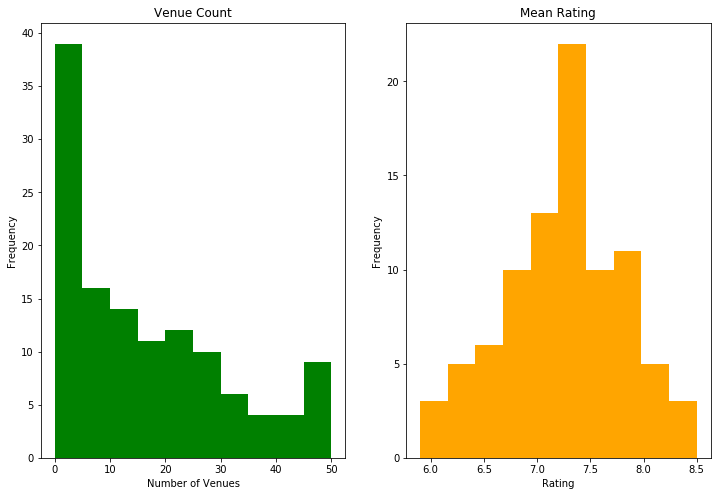

In [32]:
# Distributions of Output Variables
plt.subplot(1, 2, 1)
final_data['Venue_Count'].plot(kind='hist', figsize=(12, 8), color='green')
plt.title('Venue Count')
plt.xlabel('Number of Venues')

plt.subplot(1, 2, 2)
final_data['Mean_Rating'].plot(kind='hist', figsize=(12, 8), color='orange')
plt.title('Mean Rating')
plt.xlabel('Rating')

plt.show()

In [58]:
# output variable summaries
print(final_data['Venue_Count'].describe(),'\n')
print(final_data['Mean_Rating'].describe())

count    125.000000
mean      16.096000
std       14.596964
min        0.000000
25%        4.000000
50%       11.000000
75%       26.000000
max       50.000000
Name: Venue_Count, dtype: float64 

count    88.000000
mean      7.249512
std       0.565828
min       5.900000
25%       6.897222
50%       7.260769
75%       7.584821
max       8.500000
Name: Mean_Rating, dtype: float64


Suburbs with higher number of venues are less frequent than those with few venues.  Mean venue ratings are centred around 7.2, with a range of 5.9-8.5.

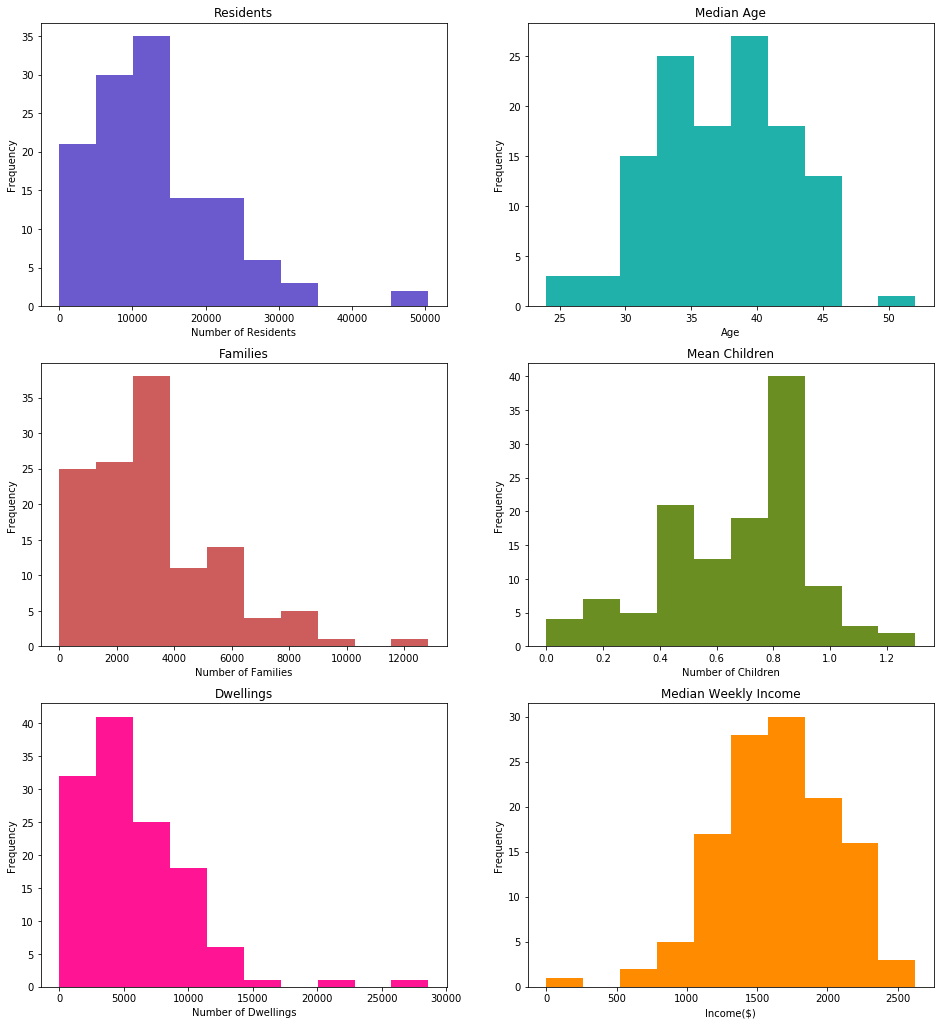

In [4]:
# Distributions of Input Variables
plt.subplot(4, 2, 1)
final_data['Residents'].plot(kind='hist', figsize=(16, 24), color='slateblue')
plt.title('Residents')
plt.xlabel('Number of Residents')

plt.subplot(4, 2, 2)
final_data['Median_age'].plot(kind='hist', color='lightseagreen')
plt.title('Median Age')
plt.xlabel('Age')

plt.subplot(4, 2, 3)
final_data['Families'].plot(kind='hist', color='indianred')
plt.title('Families')
plt.xlabel('Number of Families')

plt.subplot(4, 2, 4)
final_data['Mean_children'].plot(kind='hist', color='olivedrab')
plt.title('Mean Children')
plt.xlabel('Number of Children')

plt.subplot(4, 2, 5)
final_data['Dwellings'].plot(kind='hist', color='deeppink')
plt.title('Dwellings')
plt.xlabel('Number of Dwellings')

plt.subplot(4, 2, 6)
final_data['Median_income'].plot(kind='hist', color='darkorange')
plt.title('Median Weekly Income')
plt.xlabel('Income($)')

plt.show()

Additional features will be created to describe total income and total children per suburb.

In [5]:
# create additional features
final_data['Total_income'] = final_data['Dwellings'] * final_data['Median_income']
final_data['Total_children'] = final_data['Families'] * final_data['Mean_children']

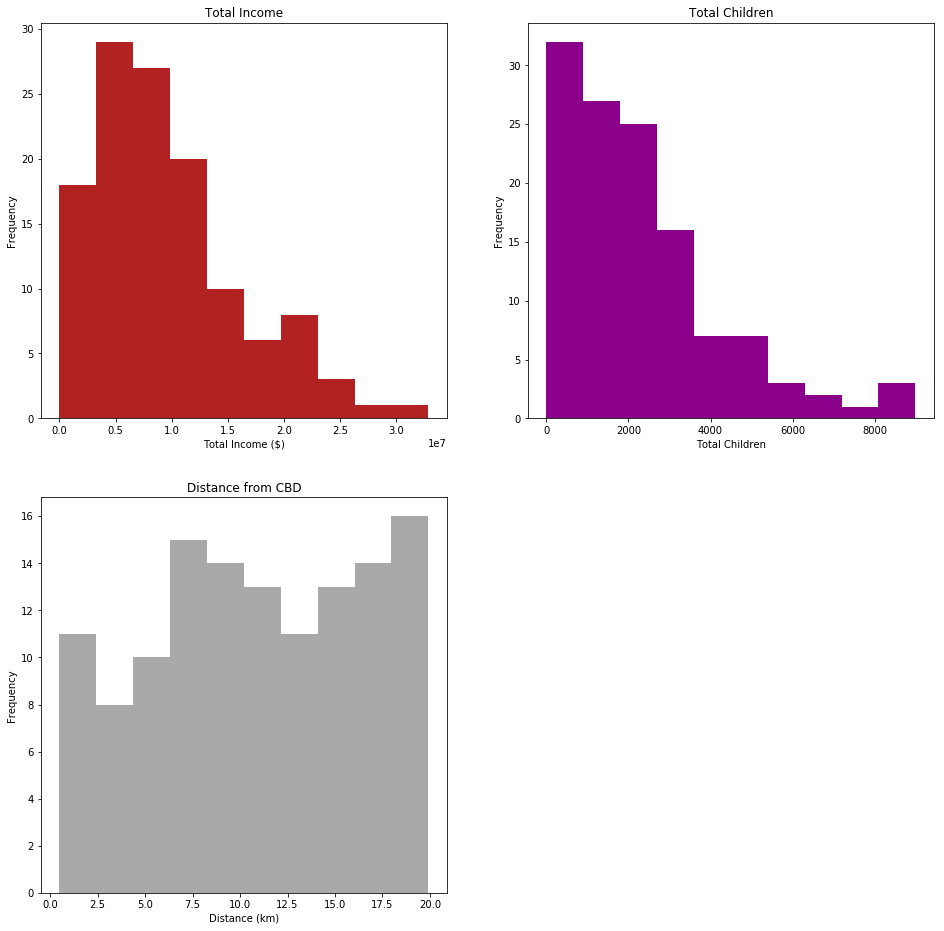

In [6]:
# Distributions of New Variables
plt.subplot(2, 2, 1)
final_data['Total_income'].plot(kind='hist', figsize=(16, 16), color='firebrick')
plt.title('Total Income')
plt.xlabel('Total Income ($)')

plt.subplot(2, 2, 2)
final_data['Total_children'].plot(kind='hist', color='darkmagenta')
plt.title('Total Children')
plt.xlabel('Total Children')

plt.subplot(2, 2, 3)
final_data['Dist_CBD'].plot(kind='hist', color='darkgray')
plt.title('Distance from CBD')
plt.xlabel('Distance (km)')

plt.show()

Residents, Families, Dwellings, Total Income and Total Children will be log transformed to increase normality of these features.

In [7]:
# take logs base 10 of Residents, Families and Dwellings
final_data['Log_Residents'] = np.log10(final_data['Residents'] + 1)
final_data['Log_Families'] = np.log10(final_data['Families'] + 1)
final_data['Log_Dwellings'] = np.log10(final_data['Dwellings'] + 1)
final_data['Log_Tot_income'] = np.log10(final_data['Total_income'] + 1)
final_data['Log_Tot_children'] = np.log10(final_data['Total_children'] + 1)

final_data.head()

,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating,Residents,Median_age,...,Mean_children,Dwellings,Median_income,Total_income,Total_children,Log_Residents,Log_Families,Log_Dwellings,Log_Tot_income,Log_Tot_children
0,Carlton,3053,-37.800153,144.966257,1.485492,16,13,7.830769,18535.0,24.0,...,0.2,10180.0,572.0,5822960.0,497.6,4.268016,3.396025,4.007790,6.765144,2.697752
1,Carlton North,3054,-37.785981,144.974578,3.158609,47,16,7.400000,6300.0,33.0,...,0.4,3067.0,2039.0,6253613.0,553.6,3.799409,3.141450,3.486855,6.796131,2.743980
2,Docklands,3008,-37.818217,144.944507,1.926197,19,7,6.757143,10964.0,30.0,...,0.2,6499.0,1868.0,12140132.0,511.2,4.040009,3.407731,3.812913,7.084223,2.709440
3,East Melbourne,3002,-37.811003,144.979694,1.275025,23,15,7.300000,4964.0,38.0,...,0.2,2923.0,2285.0,6679055.0,221.4,3.695919,3.044540,3.465977,6.824715,2.347135
4,Flemington,3031,-37.791006,144.927291,4.196574,26,10,7.220000,7719.0,33.0,...,0.6,3687.0,1171.0,4317477.0,997.2,3.887617,3.220892,3.566791,6.635230,2.999218


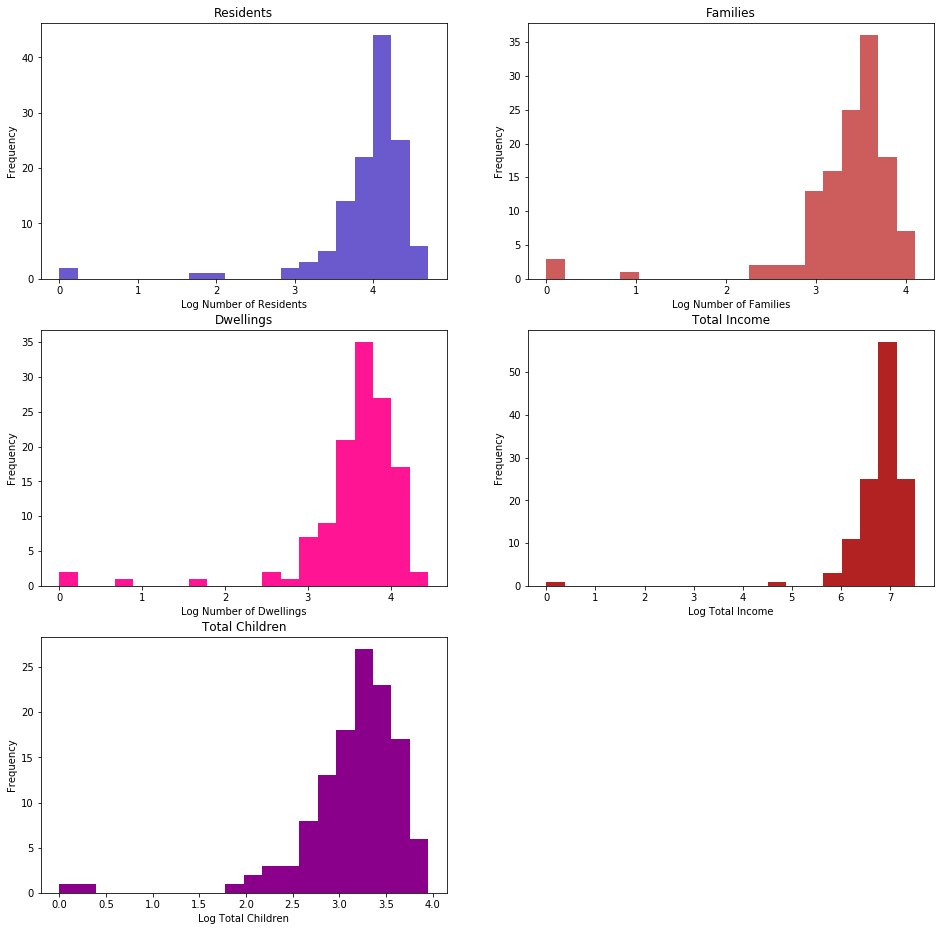

In [9]:
# Re-visualise distributions of input variables and increasing number of bins
plt.subplot(3, 2, 1)
final_data['Log_Residents'].plot(kind='hist', figsize=(16, 16), bins=20, color='slateblue')
plt.title('Residents')
plt.xlabel('Log Number of Residents')

plt.subplot(3, 2, 2)
final_data['Log_Families'].plot(kind='hist', bins=20, color='indianred')
plt.title('Families')
plt.xlabel('Log Number of Families')

plt.subplot(3, 2, 3)
final_data['Log_Dwellings'].plot(kind='hist', bins=20, color='deeppink')
plt.title('Dwellings')
plt.xlabel('Log Number of Dwellings')

plt.subplot(3, 2, 4)
final_data['Log_Tot_income'].plot(kind='hist', bins=20, color='firebrick')
plt.title('Total Income')
plt.xlabel('Log Total Income')

plt.subplot(3, 2, 5)
final_data['Log_Tot_children'].plot(kind='hist', bins=20, color='darkmagenta')
plt.title('Total Children')
plt.xlabel('Log Total Children')

plt.show()


Now we can visualise the correlations between the features and output variables.

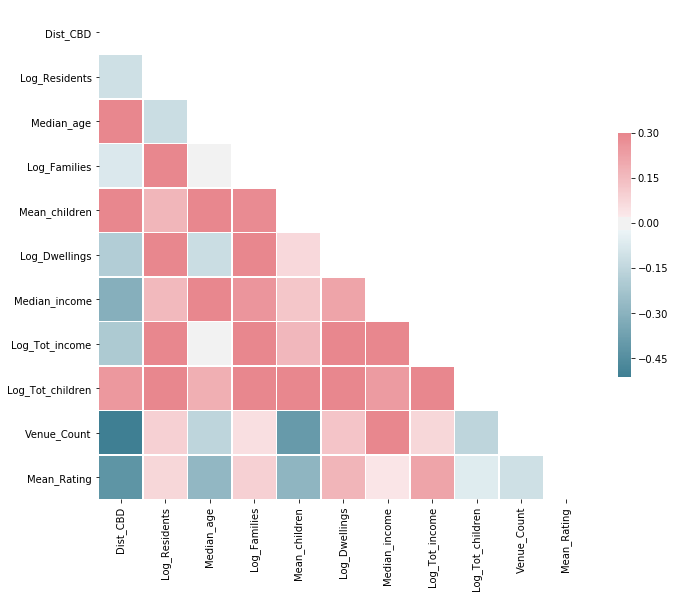

In [14]:
# use specific columns to create correlation matrix
corr_df = final_data.loc[:, ['Dist_CBD', 'Log_Residents', 'Median_age', 'Log_Families', 'Mean_children', 'Log_Dwellings', 'Median_income', 'Log_Tot_income', 'Log_Tot_children', 'Venue_Count', 'Mean_Rating']]
corr = corr_df.corr()

# create mask
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# create figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

None of the input variable correlations are particularly strong, so none require to be dropped.  Venue count appears to have the largest positive correlation with median income and the largest negative correlation with distance from CBD.  Venue rating has the largest negative correlation with distance from CBD.  These relationships are plotted below.

Text(0, 0.5, 'Venue Count')

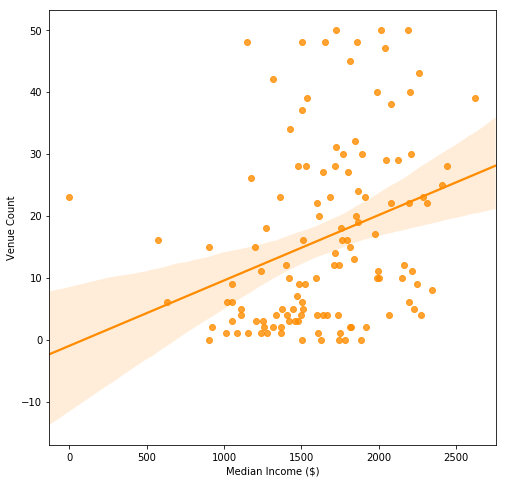

In [10]:
# plot relationship of income with venue count
plt.figure(figsize=(8, 8))
sns.regplot(x='Median_income', y='Venue_Count', color='darkorange', data=final_data)
plt.xlabel('Median Income ($)')
plt.ylabel('Venue Count')


Text(0, 0.5, 'Venue Count')

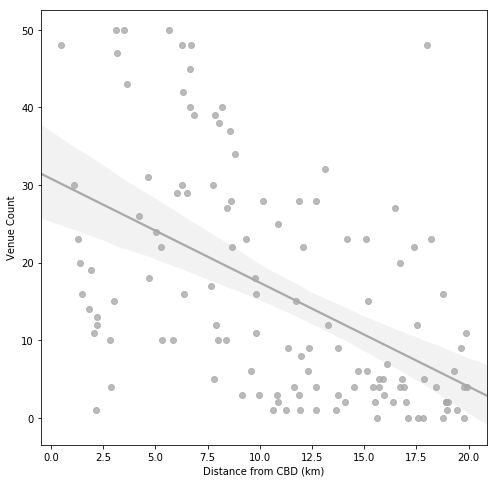

In [11]:
# plot relationship of distance with venue count
plt.figure(figsize=(8, 8))
sns.regplot(x='Dist_CBD', y='Venue_Count', color='darkgray', data=final_data)
plt.xlabel('Distance from CBD (km)')
plt.ylabel('Venue Count')


Text(0, 0.5, 'Mean Rating')

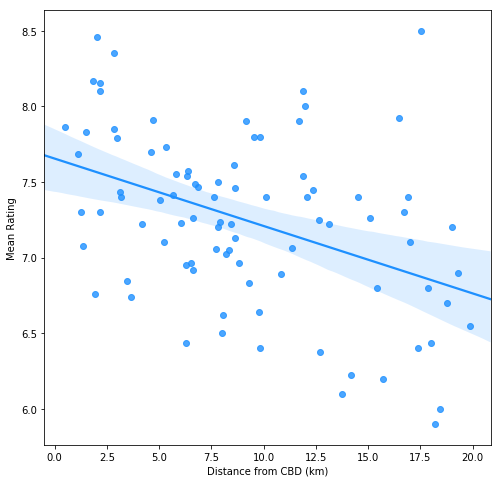

In [12]:
# plot relationship of distance with mean rating
plt.figure(figsize=(8, 8))
sns.regplot(x='Dist_CBD', y='Mean_Rating', color='dodgerblue', data=final_data)
plt.xlabel('Distance from CBD (km)')
plt.ylabel('Mean Rating')

The plots confirm that there is a weak correlation between venue count and mean suburb income.  Distance from CBD has a moderate correlation with number of venues and their mean rating.  
We can now move on to model development.

## Model Development
Machine learning models can be used to give predictions of venue count and mean rating, based on the input feature variables.  Two model types will be compared:  
* Linear Regression
* Random Forest


### Model Development for Venue Count

In [18]:
# for modelling, remove rows with missing feature data
model_data = final_data.dropna(how='any', subset=['Mean_children'])
model_data.reset_index(drop=True, inplace=True)
print('Shape:', model_data.shape)

Shape: (123, 21)


In [32]:
# Fit linear regression model to venue count data using leave one out crossvalidation
regr = linear_model.LinearRegression()
loo = LeaveOneOut()

X = np.array(model_data.loc[:, ['Dist_CBD', 'Log_Residents', 'Median_age', 'Log_Families', 'Mean_children', 'Log_Dwellings', 'Median_income', 'Log_Tot_income', 'Log_Tot_children']])
y = np.array(model_data.loc[:, ['Venue_Count']])

yhat_LR = []
                            
for train_index, test_index in loo.split(X):
                            train_x = X[train_index]
                            train_y = y[train_index]
                            regr.fit(train_x, train_y)
                            pred = regr.predict(X[test_index])
                                      
                            yhat_LR.append(pred[0][0])

yhat_LR[:5]

[23.52496465851857,
 29.122145678525726,
 31.066592242509472,
 30.156095421255117,
 21.725631781971998]

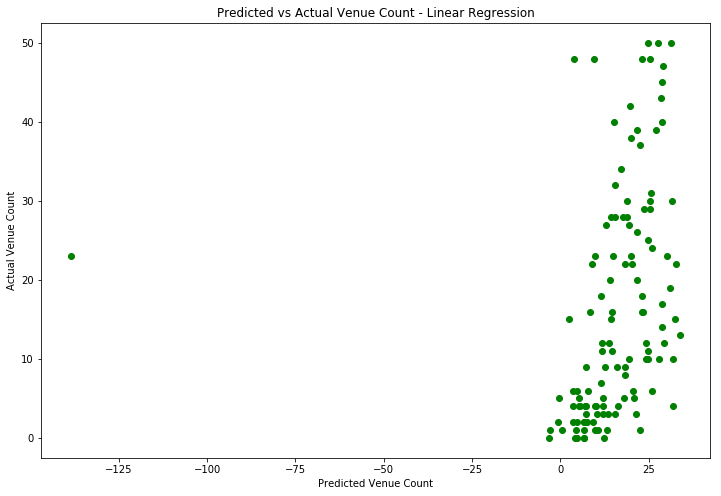

In [33]:
# plot predictions against actual values
plt.figure(figsize=(12, 8))
plt.plot(yhat_LR, model_data['Venue_Count'].tolist(), 'go')
plt.xlabel('Predicted Venue Count')
plt.ylabel('Actual Venue Count')
plt.title('Predicted vs Actual Venue Count - Linear Regression')

plt.show()

One data point is clearly an outlier, giving a negative predicted venue count.  Adding the LR predicted values to the data and determining the identity of this data point below.

In [34]:
# add yhat for LR to data and determining predictions < 0
model_data_pred = pd.concat([model_data, pd.Series(yhat_LR, name='yhat_LR')], axis=1)
model_data_pred.loc[model_data_pred['yhat_LR'] < 0, :]

,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating,Residents,Median_age,...,Dwellings,Median_income,Total_income,Total_children,Log_Residents,Log_Families,Log_Dwellings,Log_Tot_income,Log_Tot_children,yhat_LR
38,Campbellfield,3061,-37.673931,144.956762,15.513279,2,0,NaN,5056.0,36.0,...,1797.0,921.0,1655037.0,1358.5,3.703893,3.092018,3.254790,6.218808,3.133379,-0.651949
39,Coolaroo,3048,-37.658489,144.923885,17.595690,0,0,NaN,3191.0,36.0,...,1112.0,902.0,1003024.0,873.4,3.504063,2.900367,3.046495,6.001312,2.941710,-3.269693
42,Melbourne Airport,3045,-37.677280,144.850696,18.198427,23,13,5.9,104.0,33.0,...,4.0,0.0,0.0,0.0,2.021189,0.000000,0.698970,0.000000,0.000000,-138.490550
102,Albanvale,3021,-37.740779,144.798205,16.810341,5,0,NaN,5491.0,36.0,...,1914.0,1109.0,2122626.0,1455.0,3.739731,3.163161,3.282169,6.326874,3.163161,-0.270794
106,Cairnlea,3023,-37.754376,144.758008,19.426798,1,0,NaN,9657.0,33.0,...,2745.0,1748.0,4798260.0,3281.2,3.984887,3.402261,3.438701,6.681084,3.516165,-2.805494


The Melbourne Airport data is an outlier as the airport has many venues but very few residents in the census data.  This data point will be removed from the data set as it is not representative of the wider data.  The linear regression results will then be recalculated.

In [34]:
# remove Melbourne Airport data
model_data = model_data[model_data.Name != 'Melbourne Airport']
model_data.reset_index(drop=True, inplace=True)

print('Shape:', model_data.shape)

Shape: (122, 21)


In [20]:
# Re-fit linear regression model to venue count data using leave one out crossvalidation
regr = linear_model.LinearRegression()
loo = LeaveOneOut()

X = np.array(model_data.loc[:, ['Dist_CBD', 'Log_Residents', 'Median_age', 'Log_Families', 'Mean_children', 'Log_Dwellings', 'Median_income', 'Log_Tot_income', 'Log_Tot_children']])
y = np.array(model_data.loc[:, ['Venue_Count']])

yhat_LR = []
                            
for train_index, test_index in loo.split(X):
                            train_x = X[train_index]
                            train_y = y[train_index]
                            regr.fit(train_x, train_y)
                            pred = regr.predict(X[test_index])
                                      
                            yhat_LR.append(pred[0][0])

yhat_LR[:5]

[18.907208789442066,
 28.933204340755665,
 31.024431413498533,
 29.19612461008571,
 22.824766128388017]

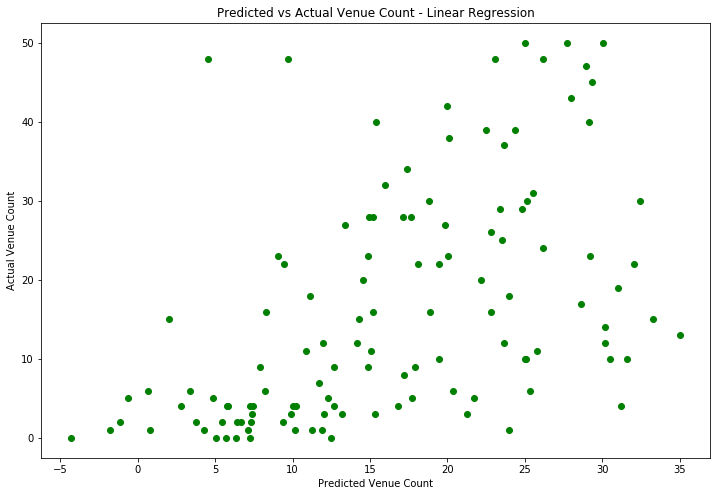

In [44]:
# plot predictions against actual values
plt.figure(figsize=(12, 8))
plt.plot(yhat_LR, model_data['Venue_Count'].tolist(), 'go')
plt.xlabel('Predicted Venue Count')
plt.ylabel('Actual Venue Count')
plt.title('Predicted vs Actual Venue Count - Linear Regression')

plt.show()

The model accuracy can be quantified using Mean Absolute Error.

In [21]:
# calculate Mean Absolute Error for linear regression data
mean_absolute_error(model_data['Venue_Count'].tolist(), yhat_LR)

10.011290322722926

We can look for insignificant feature variables to try to improve the model.

In [40]:
# model coefficients and p values of terms
y = model_data['Venue_Count']
X = model_data.loc[:, ['Dist_CBD', 'Log_Residents', 'Median_age', 'Log_Families', 'Mean_children', 'Log_Dwellings', 'Median_income', 'Log_Tot_income', 'Log_Tot_children']]
X2 = sm.add_constant(X)

lin_model = sm.OLS(y, X2).fit()
print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:            Venue_Count   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     7.789
Date:                Mon, 09 Mar 2020   Prob (F-statistic):           7.65e-09
Time:                        01:24:14   Log-Likelihood:                -470.59
No. Observations:                 122   AIC:                             961.2
Df Residuals:                     112   BIC:                             989.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.5815    207.802  

/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [49]:
# repeating the crossvalidation without Median_income and Log_Tot_income
X = np.array(model_data.loc[:, ['Dist_CBD', 'Log_Residents', 'Median_age', 'Log_Families', 'Mean_children', 'Log_Dwellings', 'Log_Tot_children']])
y = np.array(model_data.loc[:, ['Venue_Count']])

yhat_LR2 = []
                            
for train_index, test_index in loo.split(X):
                            train_x = X[train_index]
                            train_y = y[train_index]
                            regr.fit(train_x, train_y)
                            pred = regr.predict(X[test_index])
                                      
                            yhat_LR2.append(pred[0][0])

yhat_LR2[:5]

[25.59780475993226,
 26.059605342256027,
 30.12223163288344,
 27.481598107743018,
 27.804572109781816]

In [50]:
# recalculation of accuracy
mean_absolute_error(model_data['Venue_Count'].tolist(), yhat_LR2)

10.649154308567349

Accuracy is better without removing the income variables, therefore final model for linear regression includes all variables.

In [22]:
# Fit Random Forest model to venue count data using leave one out crossvalidation
rf = RandomForestRegressor(n_estimators = 1000)

X = np.array(model_data.loc[:, ['Dist_CBD', 'Log_Residents', 'Median_age', 'Log_Families', 'Mean_children', 'Log_Dwellings', 'Median_income', 'Log_Tot_income', 'Log_Tot_children']])
y = np.ravel(model_data.loc[:, ['Venue_Count']])

yhat_RF = []
                            
for train_index, test_index in loo.split(X):
                            train_x = X[train_index]
                            train_y = y[train_index]
                            rf.fit(train_x, train_y)
                            pred = rf.predict(X[test_index])
                                      
                            yhat_RF.append(pred[0])

yhat_RF[:5]


[21.715, 23.673, 17.688, 30.195, 21.424]

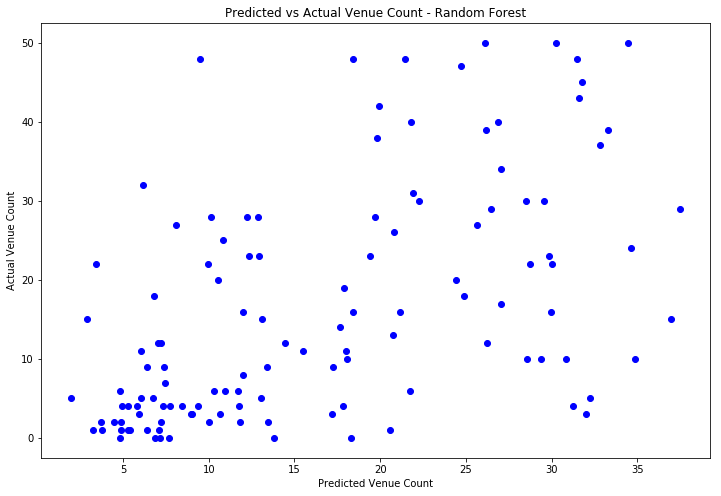

In [52]:
# plot predictions against actual values
plt.figure(figsize=(12, 8))
plt.plot(yhat_RF, model_data['Venue_Count'].tolist(), 'bo')
plt.xlabel('Predicted Venue Count')
plt.ylabel('Actual Venue Count')
plt.title('Predicted vs Actual Venue Count - Random Forest')

plt.show()

In [23]:
# calculate Mean Absolute Error for Random Forest data
mean_absolute_error(model_data['Venue_Count'].tolist(), yhat_RF)

9.803303278688526

The error for the Random Forest model is slightly lower than for Linear Regression, however it seems reasonable to use the mean of the two predictions to analyse our suburb data.  
We are interested in which suburbs are predicted to have a high number of venues but actually have a low number.  If we combine the predictions with the features data, we can use them to find suburbs that appear to be under-served.

In [24]:
# combine predictions with model data
model_data_pred = pd.concat([model_data, pd.Series(yhat_LR, name='yhat_LR'), pd.Series(yhat_RF, name='yhat_RF')], axis=1)

# calculate mean prediction
model_data_pred['yhat_mean'] = (model_data_pred['yhat_LR'] + model_data_pred['yhat_RF']) / 2

# calculate difference between mean prediction and actual data
model_data_pred['diff_count'] = model_data_pred['Venue_Count'] - model_data_pred['yhat_mean']

model_data_pred.head()

,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating,Residents,Median_age,...,Total_children,Log_Residents,Log_Families,Log_Dwellings,Log_Tot_income,Log_Tot_children,yhat_LR,yhat_RF,yhat_mean,diff_count
0,Carlton,3053,-37.800153,144.966257,1.485492,16,13,7.830769,18535.0,24.0,...,497.6,4.268016,3.396025,4.007790,6.765144,2.697752,18.907209,21.715,20.311104,-4.311104
1,Carlton North,3054,-37.785981,144.974578,3.158609,47,16,7.400000,6300.0,33.0,...,553.6,3.799409,3.141450,3.486855,6.796131,2.743980,28.933204,23.673,26.303102,20.696898
2,Docklands,3008,-37.818217,144.944507,1.926197,19,7,6.757143,10964.0,30.0,...,511.2,4.040009,3.407731,3.812913,7.084223,2.709440,31.024431,17.688,24.356216,-5.356216
3,East Melbourne,3002,-37.811003,144.979694,1.275025,23,15,7.300000,4964.0,38.0,...,221.4,3.695919,3.044540,3.465977,6.824715,2.347135,29.196125,30.195,29.695562,-6.695562
4,Flemington,3031,-37.791006,144.927291,4.196574,26,10,7.220000,7719.0,33.0,...,997.2,3.887617,3.220892,3.566791,6.635230,2.999218,22.824766,21.424,22.124383,3.875617


In [25]:
# calculate Mean Absolute Error for mean prediction
mean_absolute_error(model_data_pred['Venue_Count'].tolist(), model_data_pred['yhat_mean'].tolist())

9.63364195270255

In [26]:
# determine suburbs with largest negative difference in actual vs predicted number of coffee venues
diff_data = model_data_pred.sort_values(['diff_count'])
diff_data.loc[:, ['Name', 'Venue_Count', 'Mean_Rating', 'yhat_mean', 'diff_count']].head()

,Name,Venue_Count,Mean_Rating,yhat_mean,diff_count
21,Clifton Hill,4,7.850000,30.893908,-26.893908
104,Brooklyn,3,7.900000,26.985445,-23.985445
16,St Kilda,10,7.728571,32.477778,-22.477778
48,Pascoe Vale,5,7.500000,26.506761,-21.506761
7,Parkville,1,7.300000,22.434825,-21.434825


The suburb with the greatest difference between predicted venues and actual venues is **Clifton Hill**.  
A new coffee venue in this suburb could be recommended, based on demand for venues.

### Model Development for Mean Rating

In [35]:
# for rating modelling, remove rows with missing rating data
model_data_rating = model_data.dropna(how='any', subset=['Mean_Rating'])
model_data_rating.reset_index(drop=True, inplace=True)
print('Shape:', model_data_rating.shape)

Shape: (87, 21)


In [36]:
# Fit linear regression model to venue rating data using leave one out crossvalidation
X = np.array(model_data_rating.loc[:, ['Dist_CBD', 'Log_Residents', 'Median_age', 'Log_Families', 'Mean_children', 'Log_Dwellings', 'Median_income', 'Log_Tot_income', 'Log_Tot_children']])
y = np.array(model_data_rating.loc[:, ['Mean_Rating']])

yhat_LR = []
                            
for train_index, test_index in loo.split(X):
                            train_x = X[train_index]
                            train_y = y[train_index]
                            regr.fit(train_x, train_y)
                            pred = regr.predict(X[test_index])
                                      
                            yhat_LR.append(pred[0][0])

yhat_LR[:5]

[7.865738976205664,
 7.482471574671544,
 7.635689113374619,
 7.490181712755291,
 7.820107676323559]

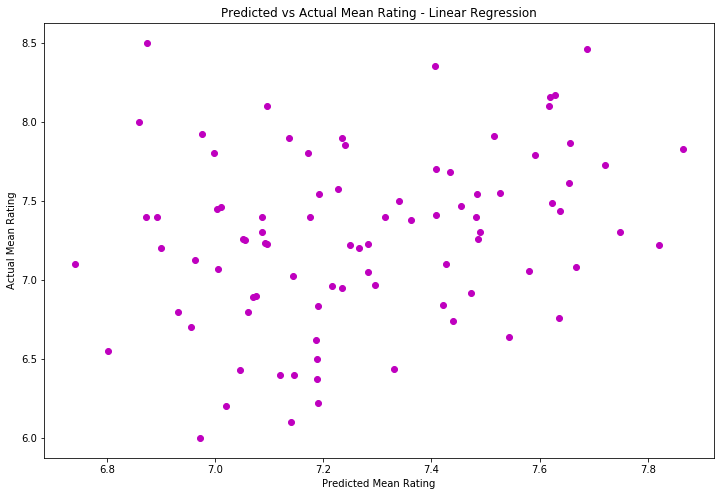

In [62]:
# plot predictions against actual values
plt.figure(figsize=(12, 8))
plt.plot(yhat_LR, model_data_rating['Mean_Rating'].tolist(), 'mo')
plt.xlabel('Predicted Mean Rating')
plt.ylabel('Actual Mean Rating')
plt.title('Predicted vs Actual Mean Rating - Linear Regression')

plt.show()

In [37]:
# calculate Mean Absolute Error for linear regression data
mean_absolute_error(model_data_rating['Mean_Rating'].tolist(), yhat_LR)

0.4246100593194931

In [38]:
# Fit Random Forest model to mean rating data using leave one out crossvalidation
X = np.array(model_data_rating.loc[:, ['Dist_CBD', 'Log_Residents', 'Median_age', 'Log_Families', 'Mean_children', 'Log_Dwellings', 'Median_income']])
y = np.ravel(model_data_rating.loc[:, ['Mean_Rating']])

yhat_RF = []
                            
for train_index, test_index in loo.split(X):
                            train_x = X[train_index]
                            train_y = y[train_index]
                            rf.fit(train_x, train_y)
                            pred = rf.predict(X[test_index])
                                      
                            yhat_RF.append(pred[0])

yhat_RF[:5]

[7.7767870586575,
 7.531281194876877,
 7.695814427029936,
 7.4143825398531495,
 7.824194985651005]

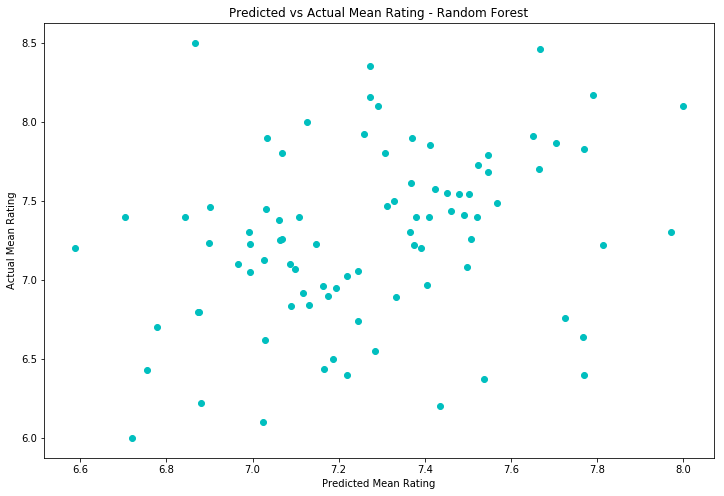

In [66]:
# plot predictions against actual values
plt.figure(figsize=(12, 8))
plt.plot(yhat_RF, model_data_rating['Mean_Rating'].tolist(), 'co')
plt.xlabel('Predicted Mean Rating')
plt.ylabel('Actual Mean Rating')
plt.title('Predicted vs Actual Mean Rating - Random Forest')

plt.show()

In [39]:
# calculate Mean Absolute Error for Random Forest data
mean_absolute_error(model_data_rating['Mean_Rating'].tolist(), yhat_RF)

0.4066170032173191

Again, the Random Forest model is slightly more accurate overall than the Linear Regression model although visually, neither is particularly predictive.  The mean of the two predictions will be assessed.

In [40]:
# combine predictions with model data
model_data_rating_pred = pd.concat([model_data_rating, pd.Series(yhat_LR, name='yhat_LR'), pd.Series(yhat_RF, name='yhat_RF')], axis=1)

# calculate mean prediction
model_data_rating_pred['yhat_mean'] = (model_data_rating_pred['yhat_LR'] + model_data_rating_pred['yhat_RF']) / 2

model_data_rating_pred.head()

,Name,Postcode,Lat,Long,Dist_CBD,Venue_Count,Rating_Count,Mean_Rating,Residents,Median_age,...,Total_income,Total_children,Log_Residents,Log_Families,Log_Dwellings,Log_Tot_income,Log_Tot_children,yhat_LR,yhat_RF,yhat_mean
0,Carlton,3053,-37.800153,144.966257,1.485492,16,13,7.830769,18535.0,24.0,...,5822960.0,497.6,4.268016,3.396025,4.007790,6.765144,2.697752,7.865739,7.776787,7.821263
1,Carlton North,3054,-37.785981,144.974578,3.158609,47,16,7.400000,6300.0,33.0,...,6253613.0,553.6,3.799409,3.141450,3.486855,6.796131,2.743980,7.482472,7.531281,7.506876
2,Docklands,3008,-37.818217,144.944507,1.926197,19,7,6.757143,10964.0,30.0,...,12140132.0,511.2,4.040009,3.407731,3.812913,7.084223,2.709440,7.635689,7.695814,7.665752
3,East Melbourne,3002,-37.811003,144.979694,1.275025,23,15,7.300000,4964.0,38.0,...,6679055.0,221.4,3.695919,3.044540,3.465977,6.824715,2.347135,7.490182,7.414383,7.452282
4,Flemington,3031,-37.791006,144.927291,4.196574,26,10,7.220000,7719.0,33.0,...,4317477.0,997.2,3.887617,3.220892,3.566791,6.635230,2.999218,7.820108,7.824195,7.822151


In [41]:
# calculate Mean Absolute Error for mean prediction
mean_absolute_error(model_data_rating_pred['Mean_Rating'].tolist(), model_data_rating_pred['yhat_mean'].tolist())

0.4109526170614079

The RF model gave the most accurate predictions and will be used for the analysis.

In [42]:
# determine suburbs with largest negative difference in actual vs predicted rating of coffee venues
model_data_rating_pred['diff_rating'] = model_data_rating_pred['Mean_Rating'] - model_data_rating_pred['yhat_RF']

diff_data_rating = model_data_rating_pred.sort_values(['diff_rating'])
diff_data_rating.loc[:, ['Name', 'Venue_Count', 'Rating_Count', 'Mean_Rating', 'yhat_RF', 'diff_rating']].head()

,Name,Venue_Count,Rating_Count,Mean_Rating,yhat_RF,diff_rating
24,Briar Hill,22,5,6.400000,7.775349,-1.375349
64,Bentleigh East,4,1,6.200000,7.396346,-1.196346
69,Chadstone,28,11,6.372727,7.533358,-1.160631
66,Caulfield East,18,5,6.640000,7.755690,-1.115690
2,Docklands,19,7,6.757143,7.695814,-0.938672


The suburb with the greatest potential for improvement in coffee venues is **Briar Hill**. However, only a small portion of venues in Briar Hill have been rated in Foursquare.  
A good quality new coffee venue in Briar Hill could potentially draw customers from existing venues.